Epoch 1/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 98s 103ms/step - accuracy: 0.8201 - loss: 0.3850 - val_accuracy: 0.9410 - val_loss: 0.1424
Epoch 2/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - accuracy: 0.9662 - loss: 0.1017 - val_accuracy: 0.9523 - val_loss: 0.1231
Epoch 3/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.9699 - loss: 0.0821 - val_accuracy: 0.9300 - val_loss: 0.1836
Epoch 4/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9555 - loss: 0.1283 - val_accuracy: 0.9643 - val_loss: 0.0911
Epoch 5/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.9821 - loss: 0.0459 - val_accuracy: 0.9601 - val_loss: 0.1232
Epoch 6/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9808 - loss: 0.0417 - val_accuracy: 0.9611 - val_loss: 0.1173
Epoch 7/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.9863 - loss: 0.0360 - val_accuracy: 0.9568 - val_loss: 0.1194


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
583/583 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9837 - loss: 0.0436


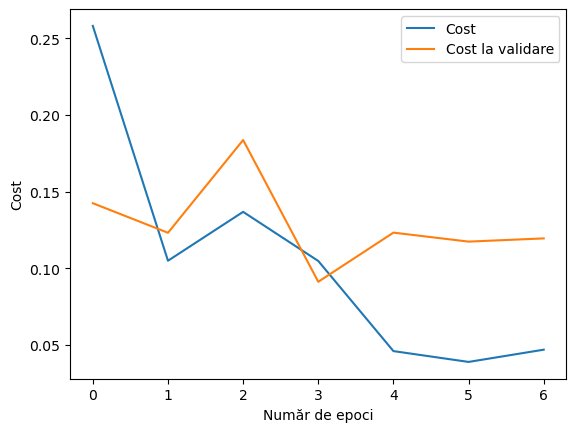

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import email
import re
import numpy as np
import warnings
import os
import joblib
import threading
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')

def phishing_analyser():
    try:
        # Funcția de preprocesare a textului
        def preprocess_text(text):
            if not isinstance(text, str):
                text = str(text)
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            text = text.lower()
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        # Încarcă setul de date
        try:
            df = pd.read_csv('..\\Data\\Phishing_Email.csv', encoding='latin-1')
        except FileNotFoundError:
            messagebox.showerror("Eroare", "Fișierul CSV nu a fost găsit.")
            return
        except Exception as e:
            messagebox.showerror("Eroare", f"A apărut o eroare la încărcarea fișierului CSV: {str(e)}")
            return

        le = LabelEncoder()
        df["Email Type"] = le.fit_transform(df["Email Type"])
        email_types = le.classes_
        df["Email Text"] = df["Email Text"].apply(preprocess_text)

        model_dir = "phishing_classifiers"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_files = {
            'Naive Bayes': os.path.join(model_dir, "model_Naive_Bayes.pkl"),
            'Logistic Regression': os.path.join(model_dir, "model_Logistic_Regression.pkl"),
            'SGD Classifier': os.path.join(model_dir, "model_SGD_Classifier.pkl"),
            'XGBoost': os.path.join(model_dir, "model_XGBoost.pkl"),
            'Decision Tree': os.path.join(model_dir, "model_Decision_Tree.pkl"),
            'Random Forest': os.path.join(model_dir, "model_Random_Forest.pkl"),
            'MLP Classifier': os.path.join(model_dir, "model_MLP_Classifier.pkl"),
            'LSTM': os.path.join(model_dir, "model_LSTM.h5")
        }
        vectorizer_file = os.path.join(model_dir, "vectorizer.pkl")
        lstm_perf_file = os.path.join(model_dir, "lstm_performance.txt")

        models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'SGD Classifier': SGDClassifier(max_iter=1000, tol=1e-3),
            'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'MLP Classifier': MLPClassifier(max_iter=1000)
        }

        if os.path.exists(vectorizer_file) and all(os.path.exists(path) for path in model_files.values()):
            try:
                vectorizer = joblib.load(vectorizer_file)
                feature_x = vectorizer.transform(df["Email Text"]).toarray()
                y_tf = np.array(df['Email Type'])
                X_train, X_test, y_train, y_test = train_test_split(feature_x, y_tf, train_size=0.8, random_state=0) # pentru clasificatori
                for model_name in models:
                    models[model_name] = joblib.load(model_files[model_name])
            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la încărcarea modelelor: {str(e)}")
                return
        else:
            try:
                vectorizer = TfidfVectorizer(max_features=10000) 
                feature_x = vectorizer.fit_transform(df["Email Text"]).toarray()
                y_tf = np.array(df['Email Type'])
                X_train, X_test, y_train, y_test = train_test_split(feature_x, y_tf, train_size=0.8, random_state=0)
                for model in models.values():
                    model.fit(X_train, y_train)
                for model_name, model in models.items():
                    joblib.dump(model, model_files[model_name])
                joblib.dump(vectorizer, vectorizer_file)
            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la antrenarea modelelor: {str(e)}")
                return

        # Adăugarea modelului LSTM
        tokenizer = Tokenizer(num_words=10000)
        tokenizer.fit_on_texts(df["Email Text"])
        sequences = tokenizer.texts_to_sequences(df["Email Text"])
        padded_sequences = pad_sequences(sequences, maxlen=200)  # Setarea maxlen la 200

        if os.path.exists(model_files['LSTM']):
            try:
                lstm_model = load_model(model_files['LSTM'])
                lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Recompilarea modelului
            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la încărcarea modelului LSTM: {str(e)}")
                return
        else:
            try:
                lstm_model = Sequential()
                lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=200))
                lstm_model.add(LSTM(units=100, return_sequences=True))
                lstm_model.add(Dropout(0.5))
                lstm_model.add(LSTM(units=100))
                lstm_model.add(Dropout(0.5))
                lstm_model.add(Dense(1, activation='sigmoid'))
                lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

                # Adăugarea early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                history = lstm_model.fit(padded_sequences, y_tf, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping]) # folosit pentru LSTM
                lstm_model.save(model_files['LSTM'])
                lstm_model.save('model_lstm.keras')
                plot_model(lstm_model, to_file='model_lstm.png', show_shapes=True)

                # Salvarea performanțelor în fișier text
                with open(lstm_perf_file, 'w') as f:
                    f.write(f"Cost: {history.history['loss']}\n")
                    f.write(f"Acuratețe: {history.history['accuracy']}\n")
                    f.write(f"Costul pe setul de validare: {history.history['val_loss']}\n")
                    f.write(f"Acuratețea pe setul de validare: {history.history['val_accuracy']}\n")

                # Generarea și salvarea graficelor
                plt.plot(history.history['accuracy'], label='Acuratețe')
                plt.plot(history.history['val_accuracy'], label='Acuratețe la validare')
                plt.xlabel('Număr de epoci')
                plt.ylabel('Acuratețe')
                plt.legend()
                plt.savefig(os.path.join(model_dir, "lstm_accuracy.png"))
                plt.clf()

                plt.plot(history.history['loss'], label='Cost')
                plt.plot(history.history['val_loss'], label='Cost la validare')
                plt.xlabel('Număr de epoci')
                plt.ylabel('Cost')
                plt.legend()
                plt.savefig(os.path.join(model_dir, "lstm_loss.png"))

            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la antrenarea modelului LSTM: {str(e)}")
                return

        def classify_email(email_text):
            email_vec = vectorizer.transform([email_text]).toarray()
            results = {}
            for model_name, model in models.items():
                try:
                    prediction = model.predict(email_vec)[0]
                    proba = model.predict_proba(email_vec)[0]
                    phishing_proba = proba[1] * 100
                    authentic_proba = proba[0] * 100
                except AttributeError:
                    prediction = model.predict(email_vec)[0]
                    phishing_proba = 0
                    authentic_proba = 0
                results[model_name] = (authentic_proba, phishing_proba)

            # Clasificare cu modelul LSTM
            try:
                email_seq = tokenizer.texts_to_sequences([email_text])
                email_pad = pad_sequences(email_seq, maxlen=200)
                lstm_prediction = lstm_model.predict(email_pad)[0]
                lstm_phishing_proba = lstm_prediction[0] * 100
                lstm_authentic_proba = (1 - lstm_prediction[0]) * 100
                results['LSTM'] = (lstm_authentic_proba, lstm_phishing_proba)
            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la clasificarea cu modelul LSTM: {str(e)}")

            return results

        def evaluate_models():
            results = {}
            for model_name, model in models.items():
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                results[model_name] = (accuracy, precision, recall)

            # Evaluare model LSTM
            try:
                lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                lstm_results = lstm_model.evaluate(padded_sequences, y_tf)
                lstm_loss = lstm_results[0]
                lstm_accuracy = lstm_results[1]
                results['LSTM'] = (lstm_accuracy, lstm_accuracy, lstm_accuracy)  # Precizie și recall sunt aproximate cu acuratețea
            except Exception as e:
                messagebox.showerror("Eroare", f"A apărut o eroare la evaluarea modelului LSTM: {str(e)}")

            return results

        mail_analyser_window = tk.Tk()
        mail_analyser_window.title("Mail Analyser")

        def on_classify():
            email_text = email_entry.get("1.0", tk.END).strip()
            if not email_text:
                messagebox.showwarning("Atenție", "Introduceți textul email-ului!")
                return
            results = classify_email(email_text)
            result_text.delete("1.0", tk.END)
            for model_name, (authentic_proba, phishing_proba) in results.items():
                result_text.insert(tk.END, f"{model_name}: ")
                result_text.insert(tk.END, f"{email_types[1]} ({authentic_proba:.2f}%)", "green")
                result_text.insert(tk.END, f" vs {email_types[0]} ({phishing_proba:.2f}%)\n", "red")

        def load_email_file():
            file_path = filedialog.askopenfilename(filetypes=[("Email files", "*.eml")])
            if file_path:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    msg = email.message_from_file(f)
                    email_body = ""
                    if msg.is_multipart():
                        for part in msg.walk():
                            if part.get_content_type() == "text/plain":
                                try:
                                    email_body = part.get_payload(decode=True).decode(errors='ignore')
                                    break
                                except Exception:
                                    continue
                    else:
                        try:
                            email_body = msg.get_payload(decode=True).decode(errors='ignore')
                        except Exception:
                            email_body = msg.get_payload()
                    email_entry.delete("1.0", tk.END)
                    email_entry.insert(tk.END, email_body)

        title_label = tk.Label(mail_analyser_window, text="Analiză Email Phishing/Autentic", font=("Arial", 16, "bold"), bg="#f0f4f7", fg="#333")
        title_label.pack(pady=10)

        email_label = tk.Label(mail_analyser_window, text="Introduceți textul email-ului:", font=("Arial", 12), bg="#f0f4f7")
        email_label.pack()
        email_entry = tk.Text(mail_analyser_window, height=10, width=50, font=("Arial", 10))
        email_entry.pack(pady=5)

        load_button = tk.Button(mail_analyser_window, text="Încarcă .eml", command=load_email_file, bg="#2196F3", fg="white", font=("Arial", 12, "bold"), width=15)
        load_button.pack(pady=5)

        classify_button = tk.Button(mail_analyser_window, text="Clasifică", command=on_classify, bg="#4CAF50", fg="white", font=("Arial", 12, "bold"), width=15)
        classify_button.pack(pady=10)

        result_text = tk.Text(mail_analyser_window, height=10, width=80, font=("Arial", 10), bg="#f0f4f7", wrap=tk.WORD)
        result_text.tag_configure("green", foreground="green")
        result_text.tag_configure("red", foreground="red")
        result_text.pack(pady=10, padx=20, fill="both")

        evaluation_results = evaluate_models()
        evaluation_text = tk.Text(mail_analyser_window, height=10, width=80, font=("Arial", 10), bg="#f0f4f7", wrap=tk.WORD)
        evaluation_text.pack(pady=10, padx=20, fill="both")
        evaluation_text.insert(tk.END, "Evaluarea Modelelor:\n")
        for model_name, (accuracy, precision, recall) in evaluation_results.items():
            evaluation_text.insert(tk.END, f"{model_name} - Acuratețe: {accuracy:.2f}, Precizie: {precision:.2f}, Recall: {recall:.2f}\n")

        mail_analyser_window.mainloop()

    except Exception as e:
        messagebox.showerror("Eroare", f"A apărut o eroare: {str(e)}")

# Rulare într-un thread separat pentru a evita blocarea interfeței
#threading.Thread(target=phishing_analyser).start()
phishing_analyser()
